In [0]:
from google.colab import files
files.upload()
!ls -lha kaggle.json
!pip install -q kaggle
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!cd ~/.kaggle/
!ls

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

import os
try:
  device_name = os.environ['COLAB_TPU_ADDR']
  TPU_ADDRESS = 'grpc://' + device_name
  print('Found TPU at: {}'.format(TPU_ADDRESS))

except KeyError:
  print('TPU not found')
  # memory footprint support libraries/code
  !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
  !pip install gputil
  !pip install psutil
  !pip install humanize
  import psutil
  import humanize
  import os
  import GPUtil as GPU
  GPUs = GPU.getGPUs()
  # XXX: only one GPU on Colab and isn’t guaranteed
  gpu = GPUs[0]
  def printm():
   process = psutil.Process(os.getpid())
   print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
   print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
  printm()

!kaggle datasets list

import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

Saving kaggle.json to kaggle.json
-rw-r--r-- 1 root root 65 Mar 31 14:14 kaggle.json
kaggle.json  sample_data
TPU not found
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.9 GB  | Proc size: 143.7 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB
ref                                                          title                                                size  lastUpdated          downloadCount  
-----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
ronitf/heart-disease-uci                                     Heart Disease UCI                                     3KB  2018-06-25 11:33:56          21990  
russellyates88/suicide-rates-overview-1985-to-2016           Suicide Rates Overview 1985 to 2016                 396KB  2018-12-01 19:18:25          16330  
lava18/g

Using TensorFlow backend.


100% 2.60G/2.62G [00:26<00:00, 158MB/s]
100% 2.62G/2.62G [00:26<00:00, 107MB/s]


In [219]:
x=pd.read_csv('hmnist_28_28_RGB.csv')
x=x[x.label !=3]
x=x[x.label !=5]
x=x[x.label !=1]
y=x['label']
print(y.iloc[5])
for i in range(0,len(y)):
    if y.iloc[i]==2:
      y.iloc[i]=1
for i in range(0,len(y)):
    if y.iloc[i]==4:
      y.iloc[i]=2
for i in range(0,len(y)):
    if y.iloc[i]==6:
      y.iloc[i]=3
      
print(x.shape)
x=x.drop('label',axis=1)


2
(9244, 2353)


In [220]:
print(y.value_counts())
mapping={4:"Melanocytic Nevi (Benign)",
        6:"Melanoma (Malignant)",
        2:"Keratosis (Benign)",
        1:"Basal Cell Carcinoma (Malignant)",
        0:"Keratosis (Malignant)",
        5:"Vascular Lesions",
        3:"Dermatofibroma"
}


2    6705
3    1113
1    1099
0     327
Name: label, dtype: int64


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.05)

In [222]:
X_train=X_train/255.0
X_test=X_test/255.0


print(Y_train.value_counts())
X_train=X_train.values.reshape(-1,28,28,3)
X_test=X_test.values.reshape(-1,28,28,3)
Y_train=Y_train.values
Y_test=Y_test.values


2    6357
3    1065
1    1047
0     312
Name: label, dtype: int64


In [0]:
Y_train=Y_train.reshape(8781,1)
Y_test=Y_test.reshape(463,1)

In [224]:
print(X_train.shape,Y_train.shape,X_test.shape,Y_test.shape)

(8781, 28, 28, 3) (8781, 1) (463, 28, 28, 3) (463, 1)


In [0]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.9)

In [0]:
import numpy as np
x_train_mean = np.mean(X_train)
x_train_std = np.std(X_train)

x_test_mean = np.mean(X_test)
x_test_std = np.std(X_test)

X_train = (X_train - x_train_mean)/x_train_std
X_test = (X_test - x_test_mean)/x_test_std

# Perform one-hot encoding on the labels
Y_train = to_categorical(Y_train, num_classes = 4)
Y_test = to_categorical(Y_test, num_classes = 4)

In [227]:
print(Y_train.shape)

(8781, 4)


In [228]:
print(X_train.shape,Y_train.shape,X_test.shape,Y_test.shape)

# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,3)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(4, activation = "softmax"))

model.summary()

(8781, 28, 28, 3) (8781, 4) (463, 28, 28, 3) (463, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_228 (Conv2D)          (None, 28, 28, 32)        2432      
_________________________________________________________________
conv2d_229 (Conv2D)          (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_230 (Conv2D)          (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_231 (Conv2D)          (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_18 (MaxP

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

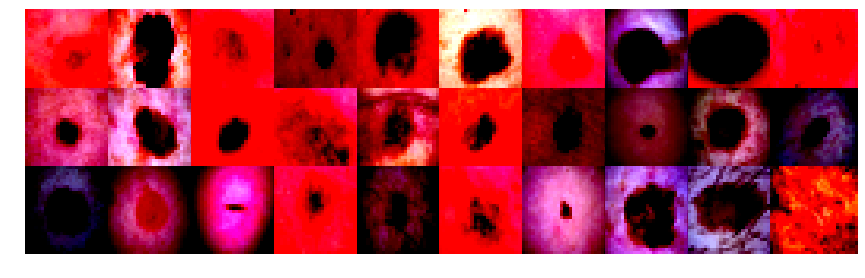

In [235]:
plt.figure(figsize=(15,4.5))
for i in range(30):  
    plt.subplot(3, 10, i+1)
    plt.imshow(X_train[i].reshape((28,28,3)),cmap=plt.cm.binary)
    plt.axis('off')
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()


# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)


 
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

epochs = 25 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 75


datagen = ImageDataGenerator(
        rotation_range=359,  
        zoom_range = 0.3,  
        width_shift_range=0.3, 
        height_shift_range=0.3,
        shear_range=10,
        horizontal_flip=True
        



)

In [232]:
print(Y_train.shape,Y_test.shape)


(8781, 4) (463, 4)


TypeError: ignored

In [236]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_test,Y_test),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              ,callbacks=[learning_rate_reduction])

Epoch 1/25
 - 13s - loss: 0.8242 - acc: 0.7164 - val_loss: 0.7722 - val_acc: 0.7603
Epoch 2/25
 - 6s - loss: 0.7351 - acc: 0.7244 - val_loss: 0.6856 - val_acc: 0.7581
Epoch 3/25
 - 6s - loss: 0.7144 - acc: 0.7237 - val_loss: 0.6317 - val_acc: 0.7689
Epoch 4/25
 - 6s - loss: 0.6847 - acc: 0.7314 - val_loss: 0.6510 - val_acc: 0.7667
Epoch 5/25
 - 6s - loss: 0.6628 - acc: 0.7397 - val_loss: 0.6308 - val_acc: 0.7754
Epoch 6/25
 - 6s - loss: 0.6509 - acc: 0.7415 - val_loss: 0.6292 - val_acc: 0.7516
Epoch 7/25
 - 6s - loss: 0.6557 - acc: 0.7380 - val_loss: 0.5782 - val_acc: 0.7775
Epoch 8/25
 - 6s - loss: 0.6585 - acc: 0.7500 - val_loss: 0.5977 - val_acc: 0.7667
Epoch 9/25
 - 6s - loss: 0.6460 - acc: 0.7510 - val_loss: 0.6439 - val_acc: 0.7646
Epoch 10/25
 - 6s - loss: 0.6278 - acc: 0.7540 - val_loss: 0.6300 - val_acc: 0.7603

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 11/25
 - 6s - loss: 0.5983 - acc: 0.7579 - val_loss: 0.5796 - val_acc: 0.7797
Epo

96
463
(463, 4)
[0.48470432 0.59488237 0.56040025 0.3627039  0.4262129  0.47428712
 0.7260885  0.42853567 0.43640476 0.48656002 0.73916453 0.49151736
 0.7348372  0.41542923 0.42648107 0.7120662  0.51219165 0.43921575
 0.505457   0.4500857  0.4661202  0.8207806  0.62988764 0.5043794
 0.38485178 0.40108812 0.5656461  0.48780337 0.68220043 0.732167
 0.60101134 0.40153825 0.6260477  0.65185106 0.49963441 0.34693557
 0.84971577 0.41837084 0.29972616 0.4758595  0.54579335 0.75481844
 0.49025798 0.3135853  0.8191524  0.6791279  0.34980744 0.5579681
 0.37346295 0.47349644 0.49240023 0.6242485  0.49313298 0.45150146
 0.6208653  0.39092517 0.7521613  0.5942283  0.48351583 0.8683292
 0.51168275 0.8310885  0.7070961  0.65393066 0.6735814  0.49254617
 0.32220003 0.45009857 0.8429326  0.6089069  0.89567333 0.75881755
 0.5410281  0.55555326 0.4189585  0.5357812  0.7106228  0.50140625
 0.9047213  0.5598264  0.43614894 0.54606694 0.6923952  0.3590446
 0.37061048 0.661536   0.6455276  0.42278764 0.41769

ValueError: ignored

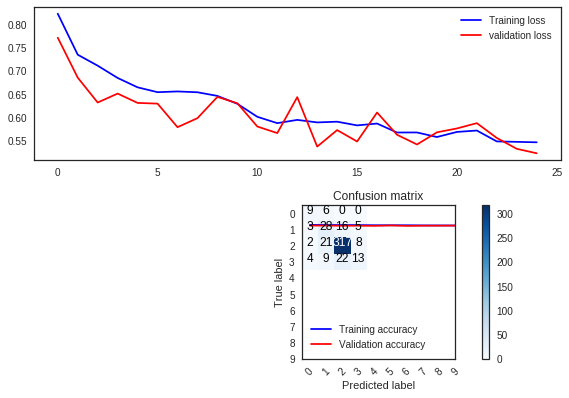

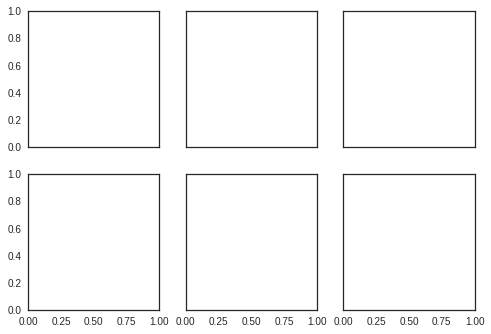

In [237]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_test[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(mapping[pred_errors[error]],mapping[obs_errors[error]]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

print(len(Y_pred_errors_prob))
print(len(errors))
print(Y_test.shape)
print(Y_pred_errors_prob)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-100:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors) 

In [0]:
# Save the weights
model.save_weights('skinskan_weights.h5')

# Save the model architecture
with open('skinskan_architecture.json', 'w') as f:
    f.write(model.to_json())


In [0]:
files.download('skinskan_architecture.json')
files.download('skinskan_weights.h5')

In [253]:
# load json and create model
from google.colab import files
from keras.models import model_from_json
import numpy as np

json_file = open('skinskan_architecture.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("skinskan_weights.h5")
print("Loaded model from disk")

y=files.upload()
im=(list(y.keys())[0])

im = cv2.imread(str(im))
im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)

Loaded model from disk


Saving ISIC_0024306.jpg to ISIC_0024306 (4).jpg


In [256]:

im=cv2.resize(im,(28,28))
plt.imshow(im)
plt.show()
im=im.reshape(-1,28,28,3)/255.0
x=model.predict(im)

i=0


first = np.argmax(x[0])



error: ignored

In [258]:
mapping={        
    0:"Keratosis (Malignant)"
    1:"Keratosis (Benign)"
    2:"Melanocytic Nevi (Benign)",
    3:"Melanoma (Malignant)",
}

print(x,mapping)
  
print("TOP "+mapping[first])

[[0.01408388 0.3277356  0.63257504 0.02560541]] {4: 'Melanocytic Nevi (Benign)', 6: 'Melanoma (Malignant)', 2: 'Keratosis (Benign)', 1: 'Basal Cell Carcinoma (Malignant)', 0: 'Keratosis (Malignant)', 5: 'Vascular Lesions', 3: 'Dermatofibroma'}
TOP Keratosis (Benign)
